In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
import FinanceDataReader as fdr
from datetime import datetime

In [2]:
from alpha_code_1 import get_alpha

In [ ]:
start_date = '2001-01-01'
end_date = '2020-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()

df = df.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df = get_alpha(df)

# 1. 결측값 채우기 (forward fill → backward fill → 0 대체)
def fill_missing(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.fillna(0)
    return df

# 2. 정규화 (표준화: 평균 0, 표준편차 1)
def normalize(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    return pd.DataFrame(scaled, index=df.index, columns=df.columns)

# 3. 이산형 / 연속형 분리
def separate_discrete_continuous(df, threshold=10):
    discrete_features = []
    continuous_features = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values <= threshold:
            discrete_features.append(col)
        else:
            continuous_features.append(col)
    return discrete_features, continuous_features

# 4. 중복 feature 제거 (feature 값이 거의 비슷한 경우 제거)
def remove_duplicate_features(df, duplicate_threshold=0.2):
    to_remove = []
    for col in df.columns:
        freq = df[col].value_counts(normalize=True).max()
        if freq > duplicate_threshold:
            to_remove.append(col)
    df_cleaned = df.drop(columns=to_remove)
    return df_cleaned, to_remove


# 5. 전체 파이프라인 함수
def clean_features(df):
    print("원본 feature 수:", df.shape[1])

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    # 이산형/연속형 분리
    discrete_features, continuous_features = separate_discrete_continuous(df)
    print(f"이산형 feature 수: {len(discrete_features)}, 연속형 feature 수: {len(continuous_features)}")

    # 중복 feature 제거
    df_cleaned, removed_features = remove_duplicate_features(df)
    print(f"중복 feature 제거 완료 (제거한 feature 수: {len(removed_features)})")

    print("최종 feature 수:", df_cleaned.shape[1])
    return df_cleaned, discrete_features, continuous_features, removed_features

# S_DQ_ 로 시작하는 원본 칼럼들은 제외하고 알파만 선택
alpha_cols = [col for col in df.columns if col.startswith('alpha')]
df_alphas_only = df[alpha_cols]

# 파이프라인 적용
df_cleaned, discrete_features, continuous_features, removed_features = clean_features(df_alphas_only)

# 1. 상관 높은 feature 제거 함수
def remove_highly_correlated_features(df, correlation_threshold=0.99):
    corr_matrix = df.corr().abs()  # 절댓값 상관계수 계산
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    
    df_cleaned = df.drop(columns=to_drop)
    
    return df_cleaned, to_drop

# 2. 40개 feature 최종 선택 (분산 큰 순서대로)
def select_top_variance_features(df, top_k=40):
    variances = df.var().sort_values(ascending=False)
    selected_features = variances.head(top_k).index.tolist()
    df_selected = df[selected_features]
    return df_selected, selected_features

# 1. 상관 높은 feature 제거
df_uncorrelated, dropped_corr_features = remove_highly_correlated_features(df_cleaned, correlation_threshold=0.99)

print(f"상관 관계로 제거한 feature 수: {len(dropped_corr_features)}")

# 2. 40개 feature 최종 선정
df_selected, selected_features = select_top_variance_features(df_uncorrelated, top_k=40)

print(f"최종 선택된 40개 feature 이름들:")
print(selected_features)

df_selected['target'] = df['UpDown']
df_selected['target'] = df_selected['target'].replace(3, 2)
df_selected['target'] = df_selected['target'].replace(1, 0)
df_selected['target'] = df_selected['target'].replace(2, 1)

In [31]:
X = df_selected.drop(columns=['target'])
y = df_selected['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = LogisticRegression(max_iter=1000)

model.fit(X_train,y_train)

#Predicting train and test set result
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("🔍 Classification Report:\n", classification_report(y_test, y_test_pred))

print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.4f}")

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       552
           1       1.00      0.99      1.00       437

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989

Train Accuracy: 0.9970
Test Accuracy: 0.9970


Threshold=0.400 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.410 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.420 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.430 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.440 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.450 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.460 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.470 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
Threshold=0.480 | Precision(1)=1.000 | Recall(1)=0.993 | Precision(0)=0.995 | Recall(0)=1.000 | Accuracy=0.997
T

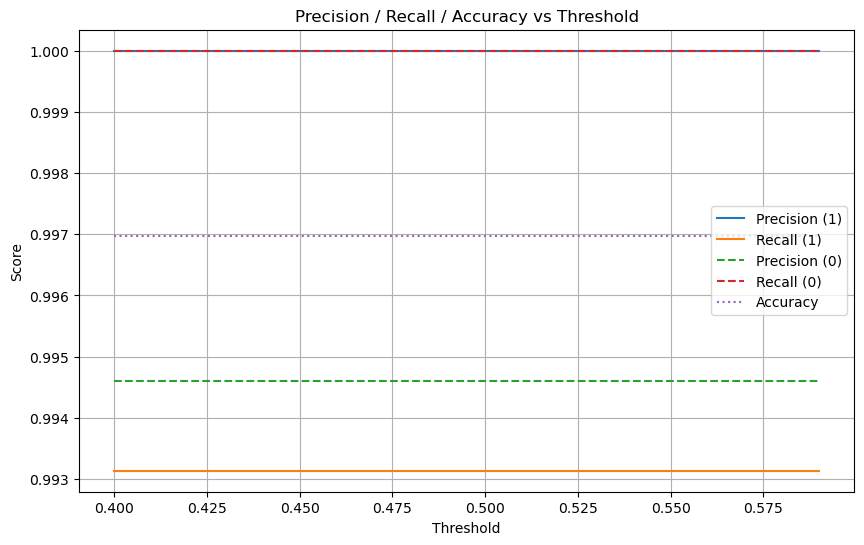

In [33]:
# 1. 확률 예측
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. threshold 리스트
thresholds = np.arange(0.4, 0.6, 0.01)

# 3. 저장할 리스트
precision_1_list = []
recall_1_list = []
precision_0_list = []
recall_0_list = []
accuracy_list = []

# 4. 각 threshold에 대해 계산
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    precision_1 = precision_score(y_test, y_pred_custom, pos_label=1)
    recall_1 = recall_score(y_test, y_pred_custom, pos_label=1)
    precision_0 = precision_score(y_test, y_pred_custom, pos_label=0)
    recall_0 = recall_score(y_test, y_pred_custom, pos_label=0)
    accuracy = accuracy_score(y_test, y_pred_custom)

    precision_1_list.append(precision_1)
    recall_1_list.append(recall_1)
    precision_0_list.append(precision_0)
    recall_0_list.append(recall_0)
    accuracy_list.append(accuracy)

# 5. 결과 출력
for t, p1, r1, p0, r0, acc in zip(thresholds, precision_1_list, recall_1_list, precision_0_list, recall_0_list, accuracy_list):
    print(f"Threshold={t:.3f} | Precision(1)={p1:.3f} | Recall(1)={r1:.3f} | Precision(0)={p0:.3f} | Recall(0)={r0:.3f} | Accuracy={acc:.3f}")

# 6. 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_1_list, label='Precision (1)', linestyle='-')
plt.plot(thresholds, recall_1_list, label='Recall (1)', linestyle='-')
plt.plot(thresholds, precision_0_list, label='Precision (0)', linestyle='--')
plt.plot(thresholds, recall_0_list, label='Recall (0)', linestyle='--')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

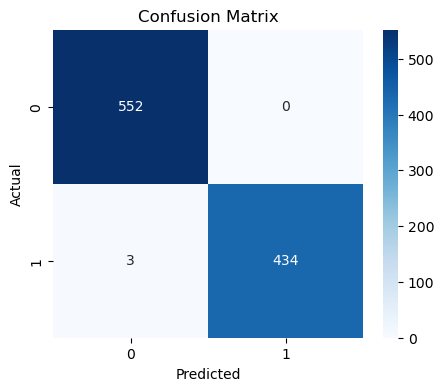

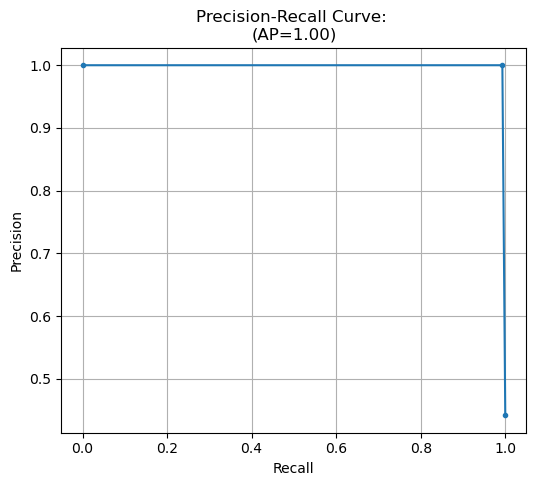

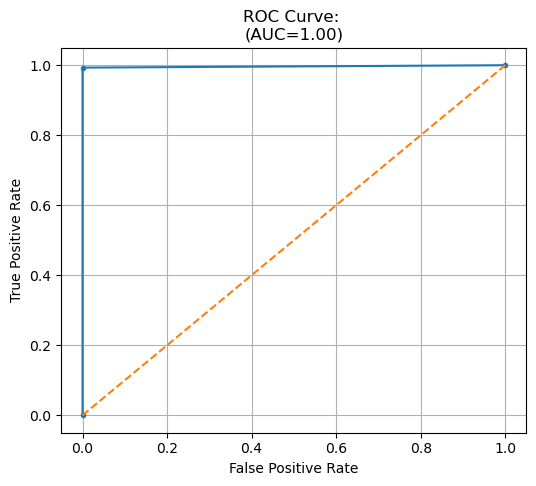


✅ Final Test Accuracy (Threshold = 0.5): 0.9970


In [34]:
#성과 분석 시각화
threshold = 0.5
y_scores = (y_pred_proba >= threshold).astype(int)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_scores)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve 시각화
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve: \n(AP={average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve: \n(AUC={roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 5. 최종 Accuracy 출력
final_accuracy = accuracy_score(y_test, y_scores)
print(f"\n✅ Final Test Accuracy (Threshold = {threshold}): {final_accuracy:.4f}")

In [69]:
start_date_actual = '2021-01-01'
end_date_actual = '2021-12-31'

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual)
df_actual = df_actual.reset_index()

df_actual = df_actual.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df_actual = get_alpha(df_actual)
features = X.columns.tolist()
df_actual = df_actual[features]

# 5. 전체 파이프라인 함수
def select_features(df):

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    return df

# 파이프라인 적용
df_selected_actual = select_features(df_actual)

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual).reset_index()
df_selected_actual['target'] = df_actual['UpDown']
df_selected_actual['target'] = df_selected_actual['target'].replace(3, 2)
df_selected_actual['target'] = df_selected_actual['target'].replace(1, 0)
df_selected_actual['target'] = df_selected_actual['target'].replace(2, 1)

X_actual = df_selected_actual.drop(columns=['target'])
y_actual = df_selected_actual['target']
y_actual_pred = model.predict(X_actual)

print("🔍 Classification Report:\n", classification_report(y_actual, y_actual_pred))

c:\Users\minju\Downloads\alpha_code_1.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner[self.returns < 0] = stddev(self.returns, 20)


결측값 채우기 완료
정규화 완료
🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       128
           1       0.99      0.93      0.96       120

    accuracy                           0.96       248
   macro avg       0.96      0.96      0.96       248
weighted avg       0.96      0.96      0.96       248



In [75]:
start_date_actual = '2025-01-01'
end_date_actual = '2025-04-20'

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual)
df_actual = df_actual.reset_index()

df_actual = df_actual.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df_actual = get_alpha(df_actual)
features = X.columns.tolist()
df_actual = df_actual[features]

# 5. 전체 파이프라인 함수
def select_features(df):

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    return df

# 파이프라인 적용
df_selected_actual = select_features(df_actual)

df_actual = fdr.DataReader('KS11', start_date_actual, end_date_actual).reset_index()
df_selected_actual['target'] = df_actual['UpDown']
df_selected_actual['target'] = df_selected_actual['target'].replace(3, 2)
df_selected_actual['target'] = df_selected_actual['target'].replace(1, 0)
df_selected_actual['target'] = df_selected_actual['target'].replace(2, 1)

X_actual = df_selected_actual.drop(columns=['target'])
y_actual = df_selected_actual['target']
y_actual_pred = model.predict(X_actual)

print("🔍 Classification Report:\n", classification_report(y_actual, y_actual_pred))

c:\Users\minju\Downloads\alpha_code_1.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inner[self.returns < 0] = stddev(self.returns, 20)


결측값 채우기 완료
정규화 완료
🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        38
           1       1.00      0.71      0.83        34

    accuracy                           0.86        72
   macro avg       0.90      0.85      0.86        72
weighted avg       0.89      0.86      0.86        72



In [76]:
# 모델의 coefficients
coefficients = model.coef_[0]  # (이진 분류면 1차원 배열)

# feature names
feature_names = X.columns

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# 영향력 큰 순서대로 정렬
importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

print(importance_df)


     feature  coefficient  abs_coefficient
11  alpha028     2.029719         2.029719
5   alpha042     1.966638         1.966638
1   alpha033     1.848885         1.848885
36  alpha101    -1.728905         1.728905
16  alpha030     1.602537         1.602537
37  alpha035    -1.104385         1.104385
33  alpha010     1.029342         1.029342
19  alpha020     0.897124         0.897124
12  alpha018     0.761861         0.761861
9   alpha005    -0.710368         0.710368
20  alpha083    -0.623448         0.623448
38  alpha019    -0.594792         0.594792
4   alpha037     0.583976         0.583976
35  alpha036     0.517101         0.517101
14  alpha006     0.396118         0.396118
23  alpha098    -0.358355         0.358355
39  alpha003     0.357591         0.357591
28  alpha039     0.332692         0.332692
10  alpha008     0.309891         0.309891
3   alpha026    -0.286498         0.286498
24  alpha072    -0.282746         0.282746
29  alpha011     0.281378         0.281378
18  alpha01